In [3]:
#load in list of URLs
import pandas as pd

#load podcast root URLs
floc = '/home/bmassi/Dropbox/professional/Insight/data/'
fname = 'itunes_categories'
podcast_categories = pd.read_csv(floc+fname)
print(podcast_categories)
print(len(podcast_categories))

                   category                                                url
0                       art  https://itunes.apple.com/us/genre/podcasts-art...
1                  business  https://itunes.apple.com/us/genre/podcasts-bus...
2                    comedy  https://itunes.apple.com/us/genre/podcasts-com...
3                 education  https://itunes.apple.com/us/genre/podcasts-edu...
4                     games  https://itunes.apple.com/us/genre/podcasts-gam...
5   government organization  https://itunes.apple.com/us/genre/podcasts-gov...
6                    health  https://itunes.apple.com/us/genre/podcasts-hea...
7                    family  https://itunes.apple.com/us/genre/podcasts-kid...
8                     music  https://itunes.apple.com/us/genre/podcasts-mus...
9                  politics  https://itunes.apple.com/us/genre/podcasts-new...
10                 religion  https://itunes.apple.com/us/genre/podcasts-rel...
11                  science  https://itunes.apple.co

In [4]:
#Grab the names and links for each podcast!
import requests
import bs4 #BeautifulSoup
import time
import re
import numpy as np

podcast_leading_character = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ*'


#gets the titles of all podcasts on an iTunes podcast category page
def get_podcast_titles_iTunes(soup,target_url = 'https://itunes.apple.com/us/podcast/'):
    
    links = []
    titles = []
    ids = []
    for link in soup.find_all('a'):
        if target_url in link.get('href'):
            links.append(link.get('href'))
            titles.append(link.contents[0])
            ids.append(link.get('href').split("/id",1)[1])
    return links, titles, ids

#count pages on an iTunes podcast category page
def count_pages_iTunes(soup):
    flag = 0
    prev_link = None
    for link in soup.find_all('a'):
        #print(link.contents)
        if link.contents[0]=='#':
            flag = 1
        if(flag):
            if(link.contents[0].isdigit()):
                prev_link = link
            else:
                if(link.contents[0]!='#'):
                    if(prev_link is None):
                        return 1
                    else:
                        return int(prev_link.contents[0])
    raise ValueError()
    
#safe request that keeps on trying if it gets a 403.
def persistent_request(url,retry_time = 60):
    flag = 1
    while(flag):
        page = requests.get(url).json()
        if(page.status_code!=200):
            flag = 1
            print('Error '+str(page.status_code)+'. Retrying in '+str(retry_time)+' sec')
            time.sleep(retry_time)
        else:
            flag = 0
    return page

inter_query_interval = 0 #seconds
inter_query_variance = 0


#store the podcast name, id, id url, time accessed, and url from where it was obtained. 
url_data = []

#setup a PIA connector


In [5]:
#Grab the names of all of the podcasts from iTunes
#IMPORTANT: these titles are truncated. When searching for id, grab both feed and title
for i in range(0,len(podcast_categories)):
    print('#########Accessing category '+str(i)+'/'+str(len(podcast_categories)))
    
    #iterate through leading characters
    for c in podcast_leading_character:
        print('######Accessing character '+c)
        base_url = re.sub('letter=.','letter='+c,podcast_categories.iloc[i]['url'])
        #request first & count pages
        request_time = time.time()
        query_time = np.random.randn()*inter_query_variance+inter_query_interval
        page = persistent_request(base_url)
        soup = bs4.BeautifulSoup(page.text,"html5lib")
        npages = count_pages_iTunes(soup)
        
        #iterate through page number
        for k in range(1,npages+1):
            print('###Accessing page #'+str(k)+'/'+str(npages))
            if(k!=1):
                #generate url
                url = re.sub('page=.','page='+str(k),base_url)
                request_time = time.time()
                page = persistent_request(url)
                soup = bs4.BeautifulSoup(page.text,"html5lib")
            else:
                url = base_url
            #get podcast titles
            links,titles,ids = get_podcast_titles_iTunes(soup)
            
            #store the podcast name, id, id url, time accessed, and url from where it was obtained. 
            for x in list(zip(titles,ids,links)):
                url_data.append([x[0],x[1],x[2],request_time,url])
            
            #file them away
            iter_end_time = time.time()
            duration = iter_end_time - request_time
            time.sleep(max(0,query_time-(duration)))
                              
url_df = pd.DataFrame(url_data,columns=['name','id','url','time_accessed','query_url'])


#########Accessing category 0/16
######Accessing character A
###Accessing page #1/13
###Accessing page #2/13
###Accessing page #3/13
###Accessing page #4/13
###Accessing page #5/13
###Accessing page #6/13
###Accessing page #7/13
###Accessing page #8/13
###Accessing page #9/13
###Accessing page #10/13
###Accessing page #11/13


KeyboardInterrupt: 

In [97]:
#save the url dataframe
import pickle
floc = '/home/bmassi/Dropbox/professional/Insight/data/'
fname = 'podcast_urls'+str(int(time.time()))
url_df.to_csv(floc+fname)

In [1]:
#load in URL dataframe
import pandas as pd

#load it in
floc = '/home/bmassi/Dropbox/professional/Insight/data/'
fname = 'podcast_urls1528605993'
url_df = pd.read_csv(floc+fname)
url_df.drop_duplicates(['id'],inplace=True)

In [2]:
#Clean up IDs
for rep in range(0,2):
    ids = url_df['id'].get_values()
    for i in range(0,len(ids)):
        #print(i)
        if(isinstance(ids[i],str)):
            if(not ids[i].isdigit()): 
                ids[i] = ids[i].split("/id",1)[1]
    url_df['id'] = ids
    
    

In [3]:
#Setup the components of querying the iTunes API for podcast RSS feeds.
import os
import random

#manages random connections to Private Internet Access
class PIAConnector:
    def __init__(self):
        self.connections = ['PIA - US Las Vegas', 'PIA - US New York City', 'PIA - US Midwest', 
               'PIA - US Atlanta', 'PIA - US Seattle', 'PIA - US East', 
               'PIA - US Chicago', 'PIA - US West', 'PIA - US Silicon Valley', 
               'PIA - US Houston', 'PIA - US Florida', 'PIA - US California', 'PIA - US Texas']
        self.used_connections = []
    
    #disconnect.
    def disconnect(self):
        os.system('pypia -d')
        
    #connect to random server that we haven't connected to before.
    def new_connection(self):
        if(len(self.connections)==0):
            self.connections = list(self.used_connections)
            self.used_connections = []
            self.disconnect()
        random.shuffle(self.connections)
        new_connect = self.connections.pop()
        pypia_command = "pypia -c '"+new_connect+"'"
        self.used_connections.append(new_connect)
        os.system(pypia_command)
        print(pypia_command)

#This request wrapper will switch servers if it gets a 403. 
def dodgy_request(url,conn):
    flag = 1
    while(flag):
        page = requests.get(url)
        if(page.status_code==403):
            flag = 1
            print('Error '+str(page.status_code)+'. Swapping server.')
            conn.new_connection()
        elif(page.status_code==200):
            flag = 0
        else:
            raise ValueError('Unrecognized status code, '+str(page.status_code))
    return page

#safe request that keeps on trying if it gets a 403.
def persistent_request(url,retry_time = 60):
    flag = 1
    while(flag):
        page = requests.get(url)
        if(page.status_code!=200):
            flag = 1
            print('Error '+str(page.status_code)+'. Retrying in '+str(retry_time)+' sec')
            time.sleep(retry_time)
        else:
            flag = 0
    return page

#wrapper for looking up a set of IDs on iTunes
def lookup_id_iTunes(id):
    return persistent_request('https://itunes.apple.com/lookup?id=' + str(id))



In [6]:
#Queries the iTunes API to get all of the RSS feeds
import numpy as np
import time
import requests

def lookup_id_iTunes(id):
    return dodgy_request('https://itunes.apple.com/lookup?id=' + str(id),conn)

conn = PIAConnector()
conn.disconnect()

chunk_size = 200

pages = []
duration = 0
for i in range(0, len(url_df), chunk_size):
    print('###### ' + str(i) + ' to ' + str(i+chunk_size) + 
          ' (last iteration '+ str(np.floor(duration)) + ')' )
    start_time = time.time()
    df_subset = url_df.iloc[i:np.min([len(url_df),(i+chunk_size)])]
    search_url = ','.join([str(x) for x in df_subset['id'].get_values()])
    pages.append(lookup_id_iTunes(search_url))
    stop_time = time.time()
    duration = stop_time - start_time


###### 0 to 200 (last iteration 0.0)
###### 200 to 400 (last iteration 0.0)
###### 400 to 600 (last iteration 0.0)
###### 600 to 800 (last iteration 0.0)
###### 800 to 1000 (last iteration 0.0)
###### 1000 to 1200 (last iteration 0.0)
###### 1200 to 1400 (last iteration 0.0)
###### 1400 to 1600 (last iteration 0.0)
###### 1600 to 1800 (last iteration 0.0)
###### 1800 to 2000 (last iteration 0.0)
###### 2000 to 2200 (last iteration 0.0)
###### 2200 to 2400 (last iteration 0.0)
###### 2400 to 2600 (last iteration 0.0)
###### 2600 to 2800 (last iteration 0.0)
###### 2800 to 3000 (last iteration 0.0)
###### 3000 to 3200 (last iteration 0.0)
###### 3200 to 3400 (last iteration 0.0)
###### 3400 to 3600 (last iteration 0.0)
###### 3600 to 3800 (last iteration 0.0)
###### 3800 to 4000 (last iteration 0.0)
###### 4000 to 4200 (last iteration 0.0)
###### 4200 to 4400 (last iteration 0.0)
###### 4400 to 4600 (last iteration 0.0)
###### 4600 to 4800 (last iteration 0.0)
###### 4800 to 5000 (last i

###### 38800 to 39000 (last iteration 0.0)
###### 39000 to 39200 (last iteration 1.0)
###### 39200 to 39400 (last iteration 0.0)
###### 39400 to 39600 (last iteration 1.0)
###### 39600 to 39800 (last iteration 1.0)
###### 39800 to 40000 (last iteration 1.0)
###### 40000 to 40200 (last iteration 1.0)
###### 40200 to 40400 (last iteration 1.0)
###### 40400 to 40600 (last iteration 0.0)
###### 40600 to 40800 (last iteration 0.0)
###### 40800 to 41000 (last iteration 0.0)
###### 41000 to 41200 (last iteration 0.0)
###### 41200 to 41400 (last iteration 0.0)
###### 41400 to 41600 (last iteration 1.0)
###### 41600 to 41800 (last iteration 1.0)
###### 41800 to 42000 (last iteration 0.0)
###### 42000 to 42200 (last iteration 0.0)
###### 42200 to 42400 (last iteration 1.0)
###### 42400 to 42600 (last iteration 0.0)
###### 42600 to 42800 (last iteration 0.0)
###### 42800 to 43000 (last iteration 1.0)
###### 43000 to 43200 (last iteration 0.0)
###### 43200 to 43400 (last iteration 0.0)
###### 4340

###### 77000 to 77200 (last iteration 0.0)
###### 77200 to 77400 (last iteration 1.0)
###### 77400 to 77600 (last iteration 1.0)
###### 77600 to 77800 (last iteration 1.0)
###### 77800 to 78000 (last iteration 0.0)
###### 78000 to 78200 (last iteration 0.0)
###### 78200 to 78400 (last iteration 0.0)
###### 78400 to 78600 (last iteration 0.0)
###### 78600 to 78800 (last iteration 1.0)
###### 78800 to 79000 (last iteration 0.0)
###### 79000 to 79200 (last iteration 0.0)
###### 79200 to 79400 (last iteration 1.0)
###### 79400 to 79600 (last iteration 0.0)
###### 79600 to 79800 (last iteration 0.0)
###### 79800 to 80000 (last iteration 0.0)
###### 80000 to 80200 (last iteration 0.0)
###### 80200 to 80400 (last iteration 1.0)
###### 80400 to 80600 (last iteration 0.0)
###### 80600 to 80800 (last iteration 1.0)
###### 80800 to 81000 (last iteration 0.0)
###### 81000 to 81200 (last iteration 1.0)
###### 81200 to 81400 (last iteration 0.0)
###### 81400 to 81600 (last iteration 0.0)
###### 8160

###### 114600 to 114800 (last iteration 0.0)
###### 114800 to 115000 (last iteration 0.0)
###### 115000 to 115200 (last iteration 0.0)
###### 115200 to 115400 (last iteration 0.0)
###### 115400 to 115600 (last iteration 0.0)
###### 115600 to 115800 (last iteration 0.0)
###### 115800 to 116000 (last iteration 0.0)
###### 116000 to 116200 (last iteration 0.0)
###### 116200 to 116400 (last iteration 0.0)
###### 116400 to 116600 (last iteration 0.0)
###### 116600 to 116800 (last iteration 1.0)
###### 116800 to 117000 (last iteration 0.0)
###### 117000 to 117200 (last iteration 0.0)
###### 117200 to 117400 (last iteration 0.0)
###### 117400 to 117600 (last iteration 0.0)
###### 117600 to 117800 (last iteration 0.0)
###### 117800 to 118000 (last iteration 1.0)
###### 118000 to 118200 (last iteration 0.0)
###### 118200 to 118400 (last iteration 1.0)
###### 118400 to 118600 (last iteration 0.0)
###### 118600 to 118800 (last iteration 0.0)
###### 118800 to 119000 (last iteration 1.0)
###### 119

###### 151200 to 151400 (last iteration 0.0)
###### 151400 to 151600 (last iteration 1.0)
###### 151600 to 151800 (last iteration 1.0)
###### 151800 to 152000 (last iteration 0.0)
###### 152000 to 152200 (last iteration 1.0)
###### 152200 to 152400 (last iteration 0.0)
###### 152400 to 152600 (last iteration 0.0)
###### 152600 to 152800 (last iteration 0.0)
###### 152800 to 153000 (last iteration 0.0)
###### 153000 to 153200 (last iteration 0.0)
###### 153200 to 153400 (last iteration 1.0)
###### 153400 to 153600 (last iteration 0.0)
###### 153600 to 153800 (last iteration 0.0)
###### 153800 to 154000 (last iteration 0.0)
###### 154000 to 154200 (last iteration 0.0)
###### 154200 to 154400 (last iteration 0.0)
###### 154400 to 154600 (last iteration 0.0)
###### 154600 to 154800 (last iteration 0.0)
###### 154800 to 155000 (last iteration 0.0)
###### 155000 to 155200 (last iteration 0.0)
###### 155200 to 155400 (last iteration 0.0)
###### 155400 to 155600 (last iteration 0.0)
###### 155

###### 187800 to 188000 (last iteration 1.0)
###### 188000 to 188200 (last iteration 0.0)
###### 188200 to 188400 (last iteration 0.0)
###### 188400 to 188600 (last iteration 0.0)
###### 188600 to 188800 (last iteration 0.0)
###### 188800 to 189000 (last iteration 1.0)
###### 189000 to 189200 (last iteration 0.0)
###### 189200 to 189400 (last iteration 0.0)
###### 189400 to 189600 (last iteration 0.0)
###### 189600 to 189800 (last iteration 0.0)
###### 189800 to 190000 (last iteration 0.0)
###### 190000 to 190200 (last iteration 1.0)
###### 190200 to 190400 (last iteration 1.0)
###### 190400 to 190600 (last iteration 1.0)
###### 190600 to 190800 (last iteration 0.0)
###### 190800 to 191000 (last iteration 0.0)
###### 191000 to 191200 (last iteration 0.0)
###### 191200 to 191400 (last iteration 1.0)
###### 191400 to 191600 (last iteration 1.0)
###### 191600 to 191800 (last iteration 0.0)
###### 191800 to 192000 (last iteration 0.0)
###### 192000 to 192200 (last iteration 1.0)
###### 192

###### 224400 to 224600 (last iteration 0.0)
###### 224600 to 224800 (last iteration 0.0)
###### 224800 to 225000 (last iteration 1.0)
###### 225000 to 225200 (last iteration 1.0)
###### 225200 to 225400 (last iteration 1.0)
###### 225400 to 225600 (last iteration 0.0)
###### 225600 to 225800 (last iteration 1.0)
###### 225800 to 226000 (last iteration 0.0)
###### 226000 to 226200 (last iteration 0.0)
###### 226200 to 226400 (last iteration 1.0)
###### 226400 to 226600 (last iteration 0.0)
###### 226600 to 226800 (last iteration 2.0)
###### 226800 to 227000 (last iteration 1.0)
###### 227000 to 227200 (last iteration 1.0)
###### 227200 to 227400 (last iteration 0.0)
###### 227400 to 227600 (last iteration 0.0)
###### 227600 to 227800 (last iteration 0.0)
###### 227800 to 228000 (last iteration 0.0)
###### 228000 to 228200 (last iteration 0.0)
###### 228200 to 228400 (last iteration 1.0)
###### 228400 to 228600 (last iteration 0.0)
###### 228600 to 228800 (last iteration 0.0)
###### 228

###### 261000 to 261200 (last iteration 1.0)
###### 261200 to 261400 (last iteration 0.0)
###### 261400 to 261600 (last iteration 1.0)
###### 261600 to 261800 (last iteration 0.0)
###### 261800 to 262000 (last iteration 2.0)
###### 262000 to 262200 (last iteration 1.0)
###### 262200 to 262400 (last iteration 0.0)
###### 262400 to 262600 (last iteration 0.0)
###### 262600 to 262800 (last iteration 0.0)
###### 262800 to 263000 (last iteration 0.0)
###### 263000 to 263200 (last iteration 0.0)
###### 263200 to 263400 (last iteration 0.0)
###### 263400 to 263600 (last iteration 1.0)
###### 263600 to 263800 (last iteration 0.0)
###### 263800 to 264000 (last iteration 0.0)
###### 264000 to 264200 (last iteration 0.0)
###### 264200 to 264400 (last iteration 0.0)
###### 264400 to 264600 (last iteration 0.0)
###### 264600 to 264800 (last iteration 1.0)
###### 264800 to 265000 (last iteration 0.0)
###### 265000 to 265200 (last iteration 0.0)
###### 265200 to 265400 (last iteration 0.0)
###### 265

###### 297600 to 297800 (last iteration 1.0)
###### 297800 to 298000 (last iteration 1.0)
###### 298000 to 298200 (last iteration 1.0)
###### 298200 to 298400 (last iteration 0.0)
###### 298400 to 298600 (last iteration 0.0)
###### 298600 to 298800 (last iteration 0.0)
###### 298800 to 299000 (last iteration 1.0)
###### 299000 to 299200 (last iteration 1.0)
###### 299200 to 299400 (last iteration 0.0)
###### 299400 to 299600 (last iteration 1.0)
###### 299600 to 299800 (last iteration 0.0)
###### 299800 to 300000 (last iteration 1.0)
###### 300000 to 300200 (last iteration 0.0)
###### 300200 to 300400 (last iteration 0.0)
###### 300400 to 300600 (last iteration 1.0)
###### 300600 to 300800 (last iteration 0.0)
###### 300800 to 301000 (last iteration 0.0)
###### 301000 to 301200 (last iteration 1.0)
###### 301200 to 301400 (last iteration 1.0)
###### 301400 to 301600 (last iteration 0.0)
###### 301600 to 301800 (last iteration 0.0)
###### 301800 to 302000 (last iteration 1.0)
###### 302

###### 334200 to 334400 (last iteration 1.0)
###### 334400 to 334600 (last iteration 0.0)
###### 334600 to 334800 (last iteration 0.0)
###### 334800 to 335000 (last iteration 0.0)
###### 335000 to 335200 (last iteration 1.0)
###### 335200 to 335400 (last iteration 0.0)
###### 335400 to 335600 (last iteration 0.0)
###### 335600 to 335800 (last iteration 1.0)
###### 335800 to 336000 (last iteration 0.0)
###### 336000 to 336200 (last iteration 0.0)
###### 336200 to 336400 (last iteration 0.0)
###### 336400 to 336600 (last iteration 0.0)
###### 336600 to 336800 (last iteration 0.0)
###### 336800 to 337000 (last iteration 0.0)
###### 337000 to 337200 (last iteration 0.0)
###### 337200 to 337400 (last iteration 0.0)
###### 337400 to 337600 (last iteration 0.0)
###### 337600 to 337800 (last iteration 0.0)
###### 337800 to 338000 (last iteration 1.0)
###### 338000 to 338200 (last iteration 0.0)
###### 338200 to 338400 (last iteration 0.0)
###### 338400 to 338600 (last iteration 0.0)
###### 338

###### 370800 to 371000 (last iteration 0.0)
###### 371000 to 371200 (last iteration 0.0)
###### 371200 to 371400 (last iteration 0.0)
###### 371400 to 371600 (last iteration 0.0)
###### 371600 to 371800 (last iteration 0.0)
###### 371800 to 372000 (last iteration 0.0)
###### 372000 to 372200 (last iteration 0.0)
###### 372200 to 372400 (last iteration 1.0)
###### 372400 to 372600 (last iteration 1.0)
###### 372600 to 372800 (last iteration 0.0)
###### 372800 to 373000 (last iteration 0.0)
###### 373000 to 373200 (last iteration 0.0)
###### 373200 to 373400 (last iteration 0.0)
###### 373400 to 373600 (last iteration 0.0)
###### 373600 to 373800 (last iteration 0.0)
###### 373800 to 374000 (last iteration 0.0)
###### 374000 to 374200 (last iteration 1.0)
###### 374200 to 374400 (last iteration 0.0)
###### 374400 to 374600 (last iteration 0.0)
###### 374600 to 374800 (last iteration 0.0)
###### 374800 to 375000 (last iteration 0.0)
###### 375000 to 375200 (last iteration 1.0)
###### 375

###### 407400 to 407600 (last iteration 0.0)
###### 407600 to 407800 (last iteration 0.0)
###### 407800 to 408000 (last iteration 0.0)
###### 408000 to 408200 (last iteration 0.0)
###### 408200 to 408400 (last iteration 0.0)
###### 408400 to 408600 (last iteration 0.0)
###### 408600 to 408800 (last iteration 0.0)
###### 408800 to 409000 (last iteration 0.0)
###### 409000 to 409200 (last iteration 0.0)
###### 409200 to 409400 (last iteration 0.0)
###### 409400 to 409600 (last iteration 1.0)
###### 409600 to 409800 (last iteration 1.0)
###### 409800 to 410000 (last iteration 0.0)
###### 410000 to 410200 (last iteration 1.0)
###### 410200 to 410400 (last iteration 0.0)
###### 410400 to 410600 (last iteration 0.0)
###### 410600 to 410800 (last iteration 1.0)
###### 410800 to 411000 (last iteration 0.0)
###### 411000 to 411200 (last iteration 0.0)
###### 411200 to 411400 (last iteration 0.0)
###### 411400 to 411600 (last iteration 1.0)
###### 411600 to 411800 (last iteration 0.0)
###### 411

413720


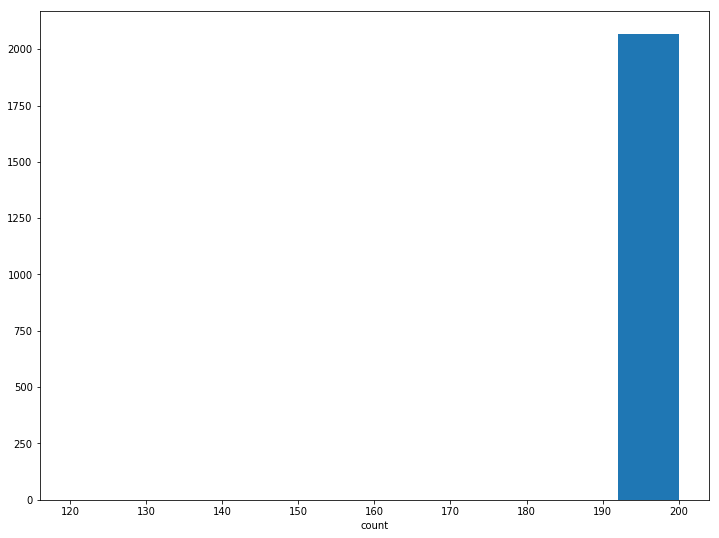

In [10]:
#plot the length of page vectors to make sure that scraping approximately worked
import matplotlib.pyplot as plt
from datetime import datetime

page_lengths = [len(x.json()['results']) for x in pages]

plt.figure(figsize=[12,9])
plt.hist(page_lengths)
plt.xlabel('# results')
plt.ylabel('count')
#print(len(url_df))


In [13]:
#save pages for later processing
import pickle

pickle.dump(pages,open(floc+'raw_itunes_requests'+str(int(time.time()))+'.pkl','wb'))

In [1]:
#load in raw iTunes requests
import pickle

floc = '/home/bmassi/Dropbox/professional/Insight/data/'
raw_itunes_requests = pickle.load(open(floc+'raw_itunes_requests1528609065.pkl','rb'))

In [2]:
#turn everything into a pandas dataframe
import pandas as pd

formatted_results = []
bads = []
cnames = ['']
for rir in raw_itunes_requests:
    for p in rir.json()['results']:
        if(p['kind']=='podcast'):
            formatted_results.append(p)

podcast_df = pd.DataFrame(formatted_results)

In [3]:
#take out rows that don't have RSS feeds
import numpy as np
podcast_df = podcast_df.loc[podcast_df['feedUrl'].isnull()==False]

#take out rows that don't have well-defined release dates
podcast_df['releaseDate'] = pd.to_datetime(podcast_df['releaseDate'])
podcast_df = podcast_df.loc[podcast_df['releaseDate'].isnull()==False]

In [4]:
#plot included podcasts as a function of update frequency
from datetime import datetime,timedelta
from matplotlib import pyplot as plt

upper_limit = 100
comparator_day = datetime(2018,6,11,14,5,23,424906)#This was "today" on Monday 6-11-18
npodcast = []
cutoffs = [i for i in range(1,upper_limit+1)]
for c in cutoffs:
    npodcast.append(np.sum(podcast_df['releaseDate'] > (comparator_day - timedelta(days=c))))

plt.plot(cutoffs,npodcast)
plt.xlabel('Time since last update threshold')
plt.ylabel('count')

Text(0,0.5,'count')

In [5]:
#filter out podcasts that weren't updated recently (look at fraction of remaining dataset as a function of cutoff)

target_cutoff = 20#filter out podcasts that weren't updated for 20 days
comparator_day = datetime(2018,6,11,14,5,23,424906)#This was "today" on Monday 6-11-18

podcast_df = podcast_df.loc[podcast_df['releaseDate'] > (comparator_day - timedelta(days=target_cutoff))]

In [ ]:
#multithreaded RSS scrape
from multiprocessing import Pool
import socket
import time
import feedparser as fp
import requests

MAX_REQUEST_DURATION = 10 #seconds
socket.setdefaulttimeout(MAX_REQUEST_DURATION)

class ResponseCodeError(BaseException):
    pass

def safe_request(url):
    flag = 1
    while(flag):
        page = requests.get(url).json()
        if(page.status_code!=200):
            flag = 1
            print('Error '+str(page.status_code)+'. Retrying in '+str(retry_time)+' sec')
            time.sleep(retry_time)
        else:
            raise ResponseCodeError()
    return page

def feed_request(url):
    try:
        return (url,fp.parse(url))
    except:
        print('Error on ' + url)
        return (url,None)

    
floc = '/home/bmassi/Dropbox/professional/Insight/data/'
if __name__ == '__main__':
    p = Pool(8)
    chunk_size = 8*16
    save_every = 1000; #save and clear rss_feeds after this many feeds have been scraped.
    rss_feeds = []
    bads = []
    duration = 0
    j = 0
    filecounter = 0
    associator = str(int(time.time()))
    for i in range(0,len(podcast_df),chunk_size):
        print('###### ' + str(i) + ' to ' + str(i+chunk_size) + 
          ' (length= ' + str(len(podcast_df))+ '; last iteration '+ str(np.floor(duration)) + ')' )
        start_time = time.time()
        podcast_df.iloc[i:np.min([len(podcast_df),(i+chunk_size)])]
        try:
            rss_feeds.append(p.map(feed_request, podcast_df['feedUrl'].iloc[i:np.min([len(podcast_df),(i+chunk_size)])].get_values()))
        except:
            print('bad on '+ str(i) + ' to ' + str(i+chunk_size))
            bads.append(range(i,i+chunk_size))
        stop_time = time.time()
        duration = stop_time - start_time
        if(j >= (save_every/chunk_size)):
            print('###Saving...')
            pickle.dump([rss_feeds,bads],open(floc+'raw_rss_and_bads_file'+
                              str(filecounter)+'_'+associator+'.pkl','wb'))
            bads = []
            rss_feeds = []
            j = -1
        j += 1
    p.close()
    
#iterate through bads

# stragglers = []
# duration = 0
# for i in range(0,len(podcast_df)):
#     print('###### ' + str(i) + ' / ' + str(len(podcast_df)) + 
#       ' (last iteration '+ str(np.floor(duration*1000)/1000) + ')' )
#     start_time = time.time()
#     podcast_df.iloc[i:np.min([len(podcast_df),(i+chunk_size)])]
#     url = podcast_df['feedUrl'].iloc[i]
#     rss_feeds.append(feed_request(url))
#     stop_time = time.time()
#     duration = stop_time - start_time
# p.close()


###### 0 to 128 (length= 106920; last iteration 0.0)
###### 128 to 256 (length= 106920; last iteration 6.0)
###### 256 to 384 (length= 106920; last iteration 8.0)
bad on 256 to 384
###### 384 to 512 (length= 106920; last iteration 11.0)
###### 512 to 640 (length= 106920; last iteration 9.0)
###### 640 to 768 (length= 106920; last iteration 13.0)
###### 768 to 896 (length= 106920; last iteration 22.0)
###### 896 to 1024 (length= 106920; last iteration 19.0)


Process ForkPoolWorker-4:
Process ForkPoolWorker-7:
Process ForkPoolWorker-6:
Process ForkPoolWorker-3:
Process ForkPoolWorker-8:
Process ForkPoolWorker-1:


Error on http://feeds.soundcloud.com/users/soundcloud:users:9848059/sounds.rss


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/bmassi/anaconda3/envs/insight/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/bmassi/anaconda3/envs/insight/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/bmassi/anaconda3/envs/insight/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/bmassi/anaconda3/envs/insight/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/bmassi/anaconda3/envs/insight/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/bmassi/anaconda3/envs/insight/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/ho

bad on 896 to 1024
###### 1024 to 1152 (length= 106920; last iteration 26.0)
Error on http://bokmassepodden.libsyn.com/rss


In [ ]:
#langdetect is slow and doesn't work on these titles. 

# from langdetect import detect
# import time

# start_time = time.time()
# lang = []
# bads = []
# for i in range(0,len(url_df)):
#     try:
#         lang.append(detect(url_df.iloc[i]['name']))
#     except:
#         lang.append('not detectable')
#         bads.append((i,url_df.iloc[i]['name']))
# stop_time = time.time()

# print((stop_time-start_time)/100)